<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_atlas_annotation_Scanpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of single-cell RNA-seq data: building and annotating an atlas
This notebook pre-processes the [pbmc_1k v3 dataset](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_1k_v3) from 10X Genomics with `kb` and then performs an analysis of the cell types and their marker genes.

The notebook was written by A. Sina Booeshaghi and Lior Pachter and is based on three noteboks:
- The kallisto | bustools [Introduction to single-cell RNA-seq I](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_1_minute_intro.ipynb#scrollTo=wtwMjIjjCMcD) notebook.
- The kallisto | bustools [Introduction to single-cell RNA-seq II](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_standard.ipynb#scrollTo=ijU_u6uj3Sio) notebook.
- The Scanpy [Preprocessing and clustering 3k PBMCs" notebook](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

If you use the methods in this notebook for your analysis please cite the following publications which describe the tools used in the notebook:

* Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. bioRxiv (2019). doi:10.1101/673285
* Wolf, F. A., Angere, P. and Theis, F.J. SCANPY: large-scale single-cell gene expression data analysis. Genome Biology (2018). doi:10.1186/s13059-017-1382-0


## Setup

In [0]:
# This is  used to time the running of the notebook
import time
start_time = time.time()

### Install python packages

In [2]:
%%time
# These packages are pre-installed on Google Colab, but are included here to simplify running this notebook locally
!pip install matplotlib
!pip install scikit-learn
!pip install numpy
!pip install scipy

CPU times: user 124 ms, sys: 29.2 ms, total: 153 ms
Wall time: 12.9 s


In [3]:
%%time
# install the "Leiden" clustering package
!pip3 install leidenalg

     |████████████████████████████████| 102kB 5.2MB/s 
     |████████████████████████████████| 378kB 8.3MB/s 
  Created wheel for leidenalg: filename=leidenalg-0.7.0-cp36-cp36m-linux_x86_64.whl size=1105592 sha256=62daa9200d8f797bd10a3d308cf0aeee7ac90877808302ecfe4d9287968c6d52
  Stored in directory: /root/.cache/pip/wheels/29/55/48/5a04693a10f50297bcda23819ca23ab3470a61dd911851c8bd
  Created wheel for python-igraph: filename=python_igraph-0.7.1.post6-cp36-cp36m-linux_x86_64.whl size=2217490 sha256=17936cf0a4f53b5e8bd803f8ffff83bd61e75d32fd2ccbf95b7b82fd68406e9e
  Stored in directory: /root/.cache/pip/wheels/41/d6/02/34eebae97e25f5b87d60f4c0687e00523e3f244fa41bc3f4a7
Successfully built leidenalg python-igraph
CPU times: user 1.64 s, sys: 197 ms, total: 1.84 s
Wall time: 6min 8s


In [4]:
%%time
# install kb
!pip install kb-python scanpy


     |████████████████████████████████| 35.4MB 119kB/s 
     |████████████████████████████████| 6.5MB 48.3MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 13.0MB 39.9MB/s 
     |████████████████████████████████| 2.9MB 34.1MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
  Created wheel for loompy: filename=loompy-3.0.6-cp36-none-any.whl size=47896 sha256=38302e394bb6dfd18ab952ed87c5f9c825adc852216dbf2c7f47baf8277ee664
  Stored in directory: /root/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Created wheel for numpy-groupies: filename=numpy_groupies-0+unknown-cp36-none-any.whl size=28044 sha256=d42b846246b3980864a244ba7f7273876412e325f17c719fcb6de88194fd1970
  Stored in directory: /root/.cache/pip/wheels/30/ac/83/64d5f9293aeaec63f9539142fc629a41af064cae1b3d8d94aa
Successfully built lo

CPU times: user 709 ms, sys: 112 ms, total: 821 ms
Wall time: 36.1 s


In [0]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt


In [6]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.5.post3 anndata==0.7.1 umap==0.3.10 numpy==1.17.5 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.10.2 python-igraph==0.7.1


### Download the data

In [7]:
%%time
# Download the data from the 10x website
!wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_fastqs.tar

# unpack the downloaded files
!tar -xvf pbmc_1k_v3_fastqs.tar

--2020-02-03 06:04:41--  http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_fastqs.tar
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 54.240.168.60, 54.240.168.99, 54.240.168.70, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|54.240.168.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5549312000 (5.2G) [application/x-tar]
Saving to: ‘pbmc_1k_v3_fastqs.tar’

pbmc_1k_v3_fastqs.t 100%[===================>]   5.17G  54.4MB/s    in 73s     

2020-02-03 06:05:54 (72.5 MB/s) - ‘pbmc_1k_v3_fastqs.tar’ saved [5549312000/5549312000]

pbmc_1k_v3_fastqs/
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_I1_001.fastq.gz
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_I1_001.fastq.gz
CPU times: user 1.45 s, sys: 229 ms, total: 1.68 s
Wall time: 3min 22

### Download an index

This data consists of peripheral blood mononuclear cells from a human, so we download the human index.

In [8]:
!kb ref -d human -i index.idx -g t2g.txt -f1 transcriptome.fasta

[2020-02-03 06:08:07,585]    INFO Downloading files for human from https://caltech.box.com/shared/static/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz to tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
[2020-02-03 06:11:32,410]    INFO Extracting files from tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz


## Pseudoalignment and counting

### Run kallisto and bustools

In [9]:
%%time
!kb count --h5ad -i index.idx -g t2g.txt -x 10xv3 -o output --filter bustools -t 2 \
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz \
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz \
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz \
pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz

[2020-02-03 06:12:21,916]    INFO Generating BUS file from
[2020-02-03 06:12:21,916]    INFO         pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz
[2020-02-03 06:12:21,916]    INFO         pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz
[2020-02-03 06:12:21,916]    INFO         pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz
[2020-02-03 06:12:21,916]    INFO         pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz
[2020-02-03 06:23:37,802]    INFO Sorting BUS file output/output.bus to tmp/output.s.bus
[2020-02-03 06:24:10,478]    INFO Whitelist not provided
[2020-02-03 06:24:10,478]    INFO Copying pre-packaged 10XV3 whitelist to output
[2020-02-03 06:24:11,599]    INFO Inspecting BUS file tmp/output.s.bus
[2020-02-03 06:24:24,979]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist output/10xv3_whitelist.txt
[2020-02-03 06:27:27,761]    INFO Sorting BUS file tmp/output.s.c.bus to output/output.unfiltered.bus
[2020-02-03 06:27:39

## Basic QC

In [0]:
results_file = 'pbmc1k.h5ad'  # the file that will store the analysis results

In [0]:
adata = anndata.read_h5ad("output/counts_filtered/adata.h5ad")
adata.var["gene_id"] = adata.var.index.values

In [0]:
t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

In [0]:
adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]

In [0]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [15]:
adata

AnnData object with n_obs × n_vars = 1185 × 60623 
    var: 'gene_id', 'gene_name'

### Represent the cells in 2D with PCA

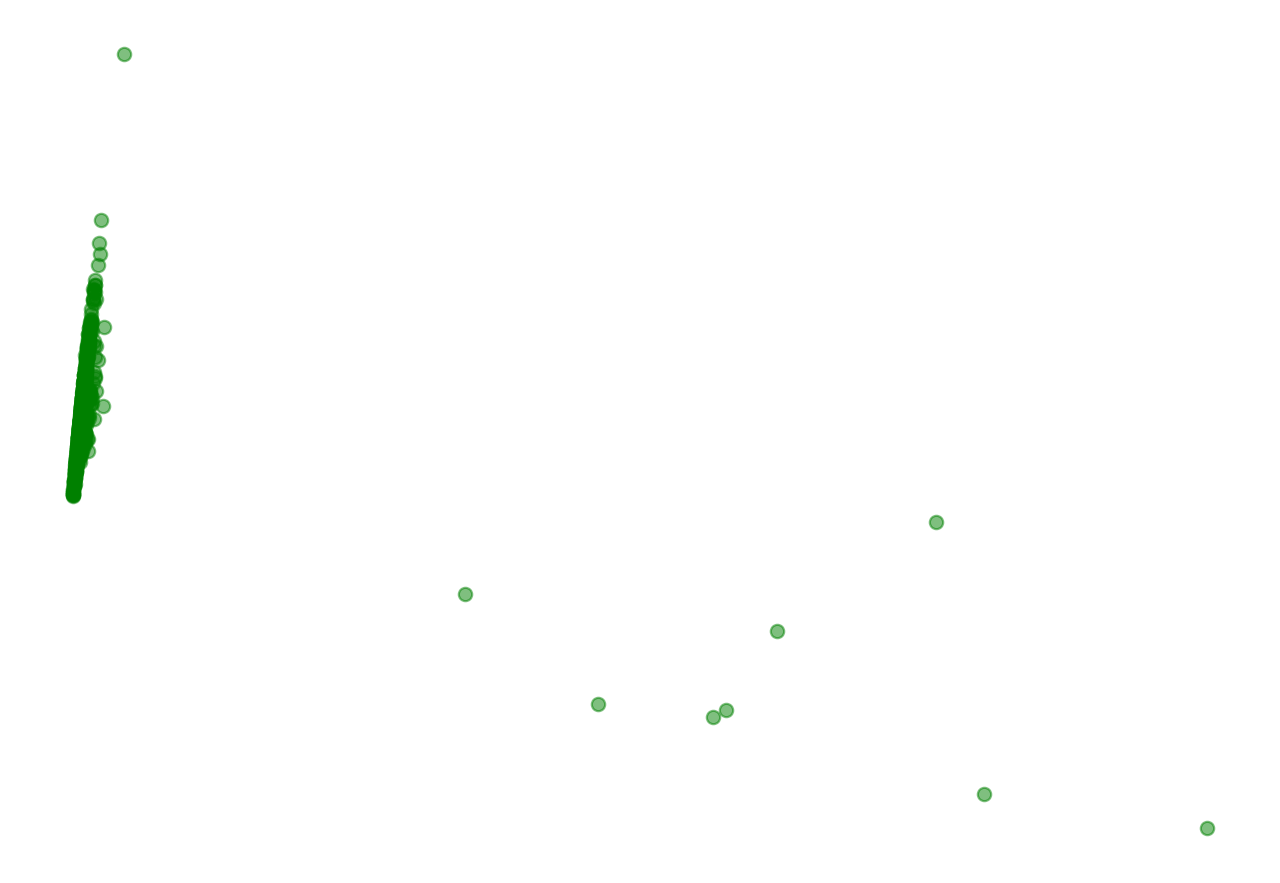

In [16]:
# Perform SVD
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(adata.X)
X = tsvd.transform(adata.X)

# Plot the cells in the 2D PCA projection
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X[:,0], X[:,1], alpha=0.5, c="green")

plt.axis('off')
plt.show()

### Test for library saturation

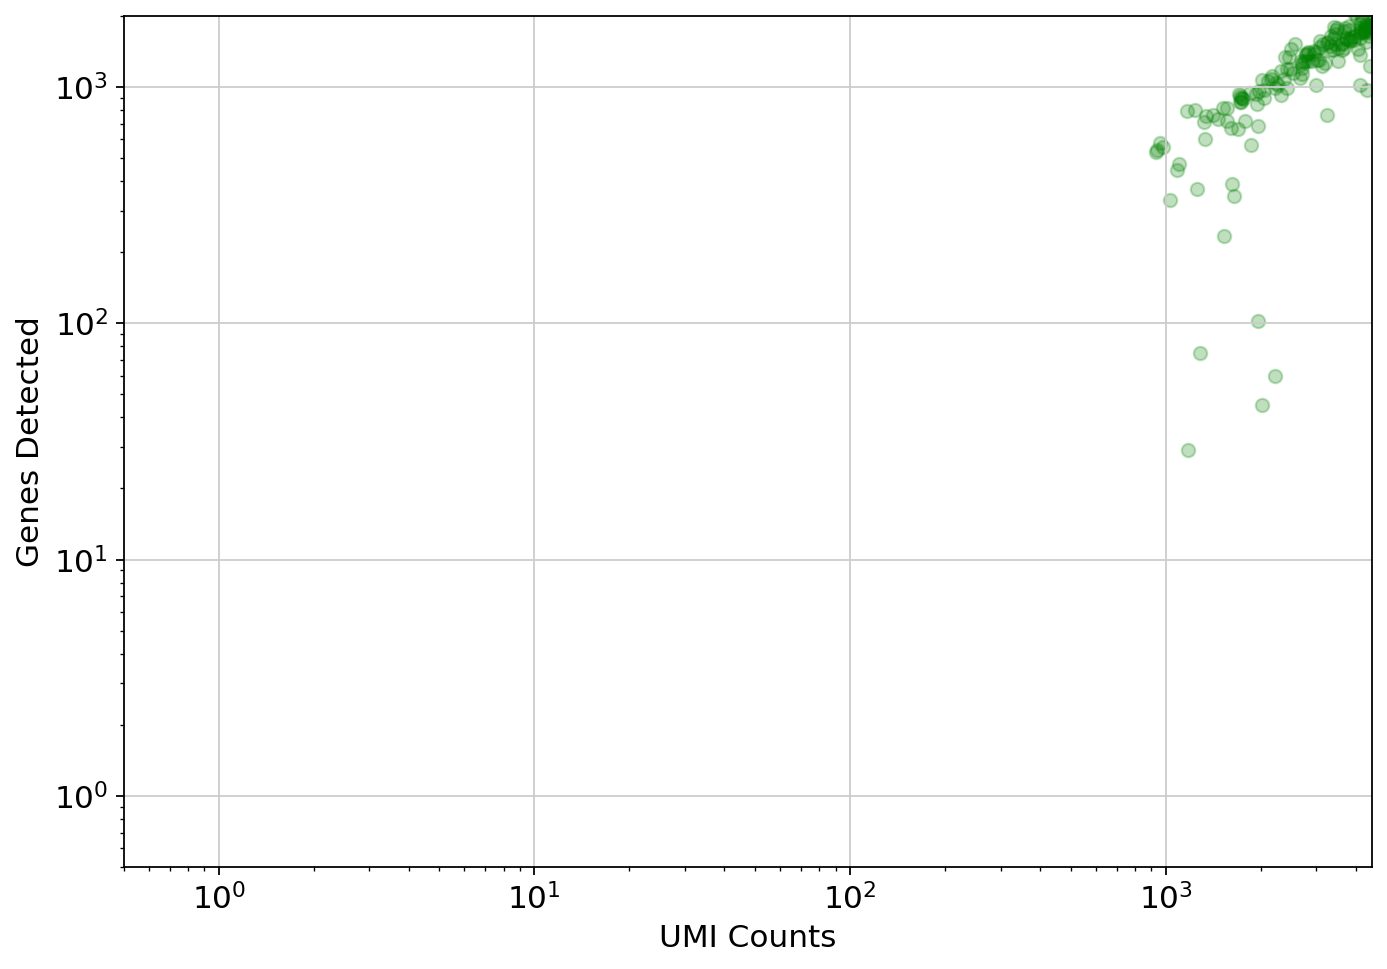

In [17]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(adata.X.sum(axis=1))[:,0], np.asarray(np.sum(adata.X>0, axis=1))[:,0], color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonposy='clip')

ax.set_xlim((0.5, 4500))
ax.set_ylim((0.5,2000))


plt.show()

### Examine the knee plot

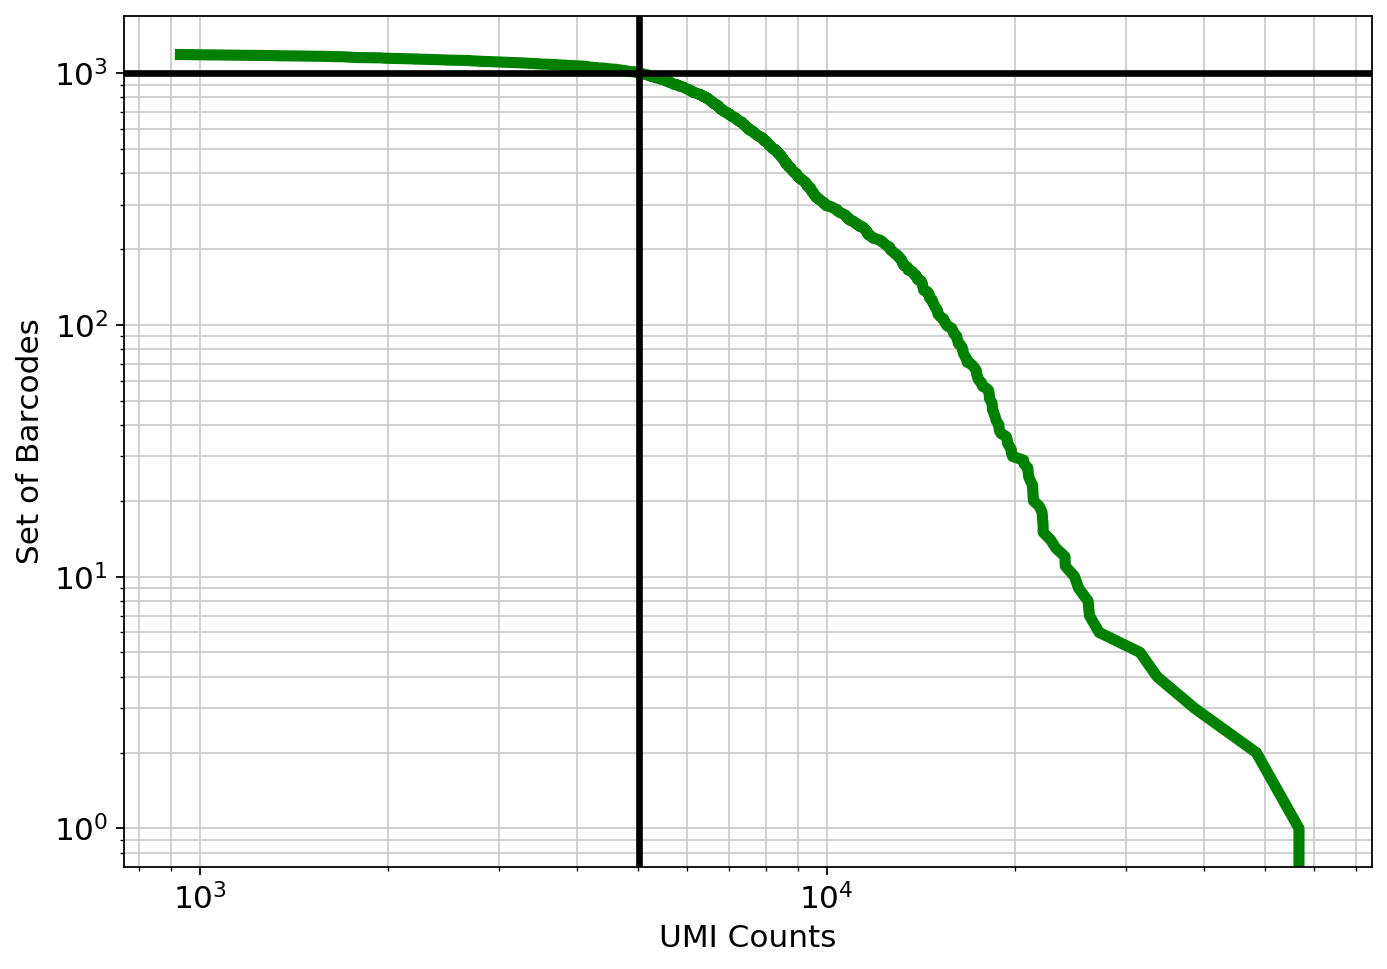

In [18]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
expected_num_cells =  1000#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing counts per cell
    finished (0:00:00)


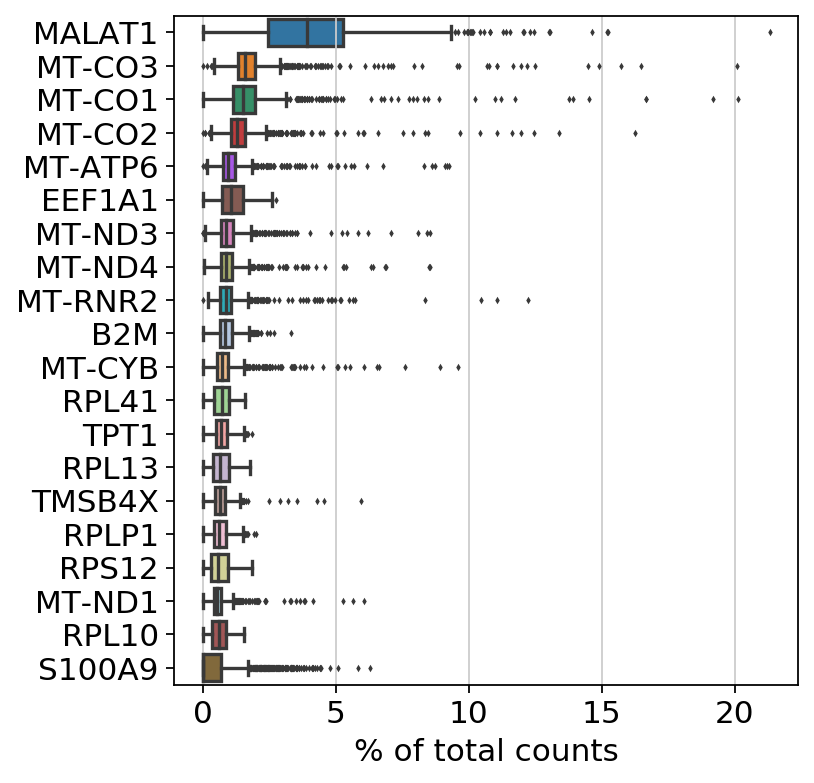

In [19]:
sc.pl.highest_expr_genes(adata, n_top=20, )

It is useful to examine mitochondrial genes, which are important for quality control. [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics) write that

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

Note you can also use the function `pp.calculate_qc_metrics` to compute the fraction of mitochondrial genes and additional measures.

In [0]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

## Analysis

### Filter

Begin by filtering cells according to various criteria. First, a filter for genes and cells based on minimum thresholds:

In [21]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 5 cells that have less than 200 genes expressed


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 34669 genes that are detected in less than 3 cells


Next, filter by mitochondrial gene content

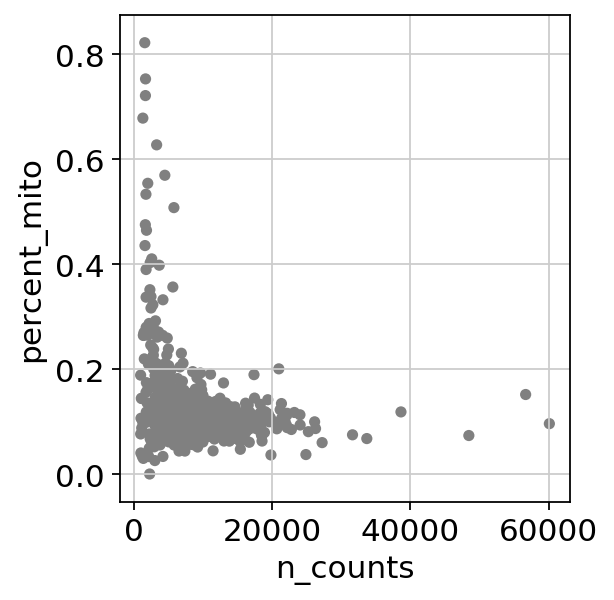

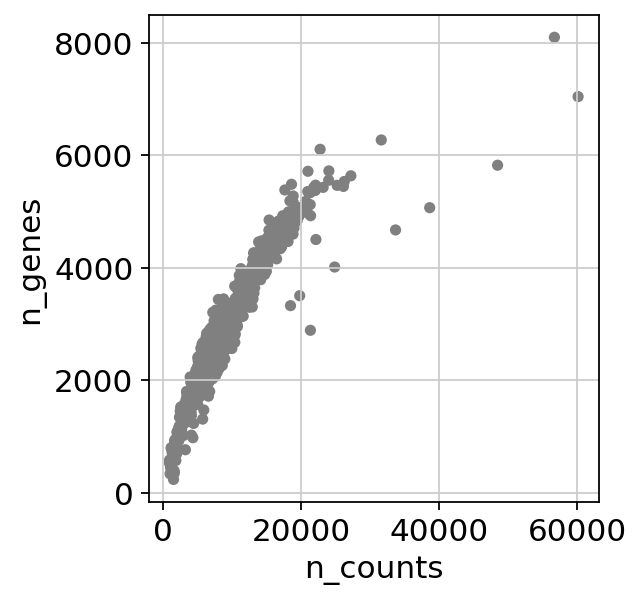

In [22]:
#examine mitochondrial content 
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

#filter
adata = adata[adata.obs.n_genes < 20000, :]
adata = adata[adata.obs.percent_mito < 0.2, :]

In [23]:
adata

View of AnnData object with n_obs × n_vars = 1122 × 25954 
    obs: 'percent_mito', 'n_counts', 'n_genes'
    var: 'gene_id', 'gene_name', 'n_cells'

Perform a QC check of the counts post-filtering

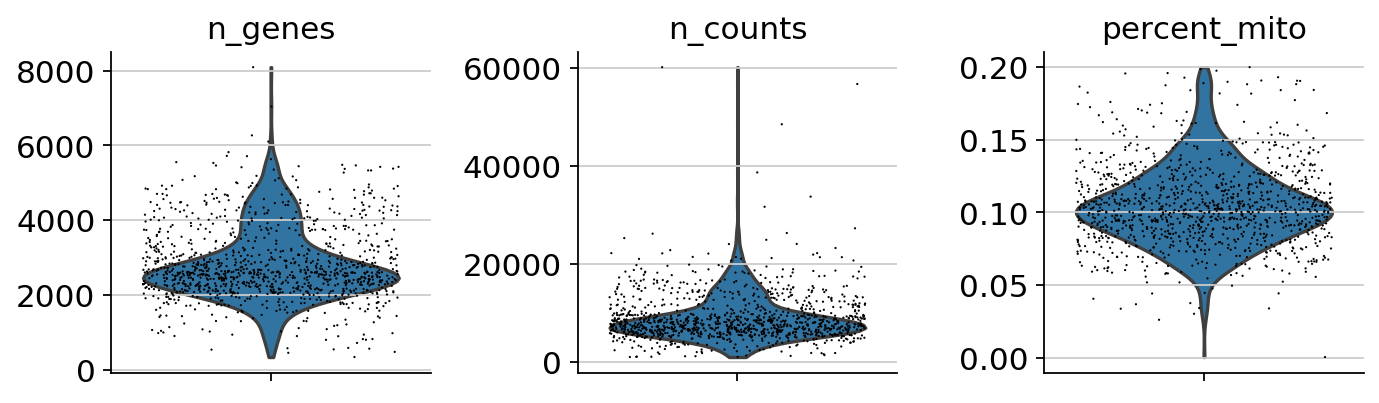

In [24]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

### Normalize counts

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [25]:
# normalize counts in each cell to be equal
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:02)


Log the counts

In [26]:
# Replace raw counts with their logarithm
sc.pp.log1p(adata)

/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


Set the `.raw` attribute of AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

The unnormalized data is stored in `.raw`.

In [0]:
adata.raw = adata

<div class="alert alert-info">

**Note**
    
If you don't proceed below with correcting the data with `sc.pp.regress_out` and scaling it via `sc.pp.scale`, you can also get away without using `.raw` at all.

The result of the following highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.

</div>

Identify highly-variable genes.

In [28]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


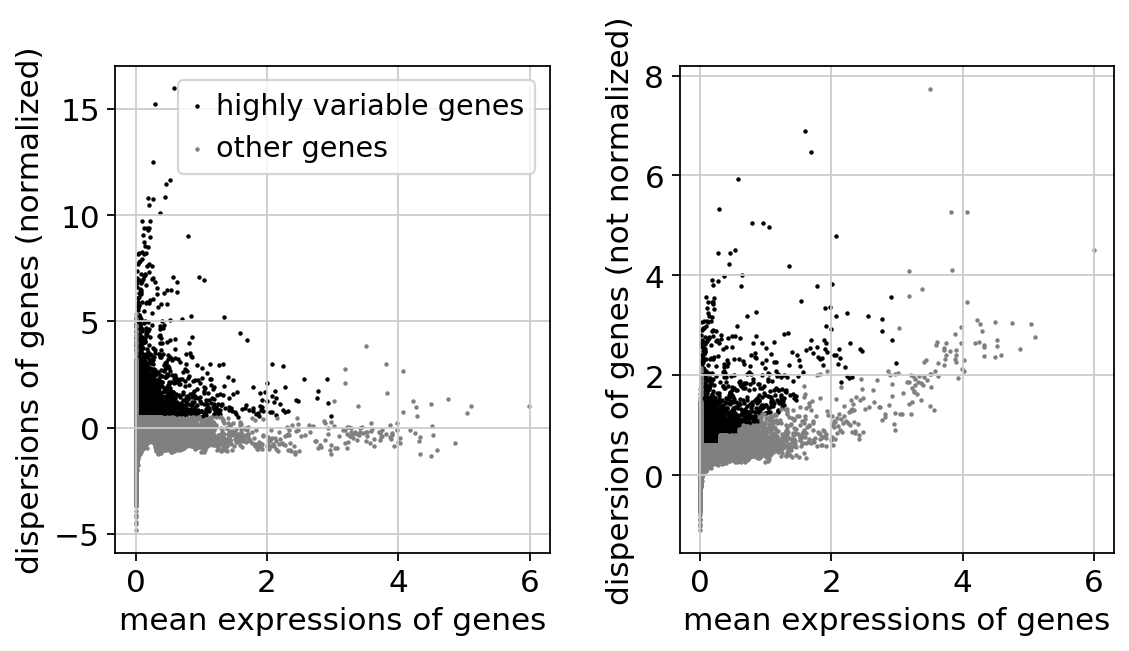

In [29]:
sc.pl.highly_variable_genes(adata)

Actually do the filtering.

In [0]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [31]:
adata

View of AnnData object with n_obs × n_vars = 1122 × 4344 
    obs: 'percent_mito', 'n_counts', 'n_genes'
    var: 'gene_id', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

We do not regress out as per https://github.com/theislab/scanpy/issues/526

In [0]:
# sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [33]:
sc.pp.scale(adata, max_value=10)

/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:909: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [34]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)


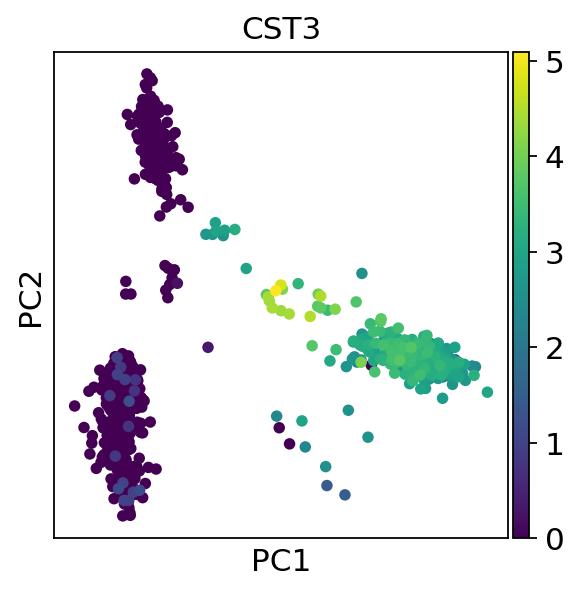

In [35]:
sc.pl.pca(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

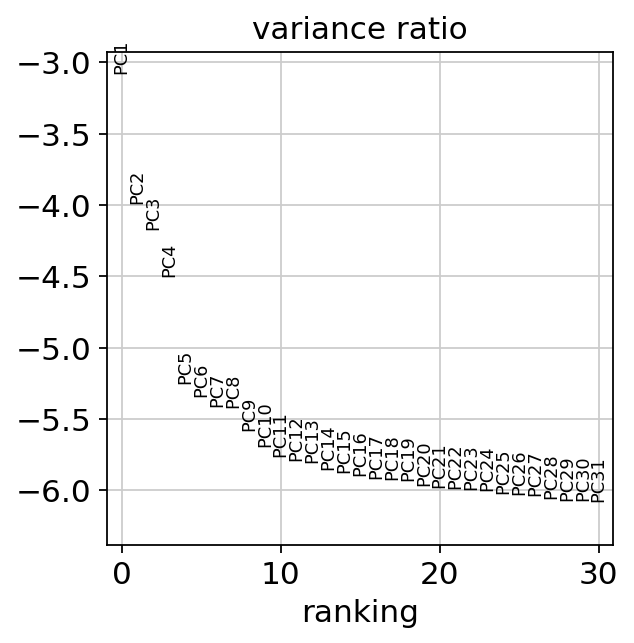

In [36]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result if you'd like.

In [0]:
!mkdir write

In [0]:
adata.write(results_file)

In [39]:
adata

AnnData object with n_obs × n_vars = 1122 × 4344 
    obs: 'percent_mito', 'n_counts', 'n_genes'
    var: 'gene_id', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Compute the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [40]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


### Embed the neighborhood graph

We advertise embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is  potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [41]:
sc.tl.umap(adata)

computing UMAP


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


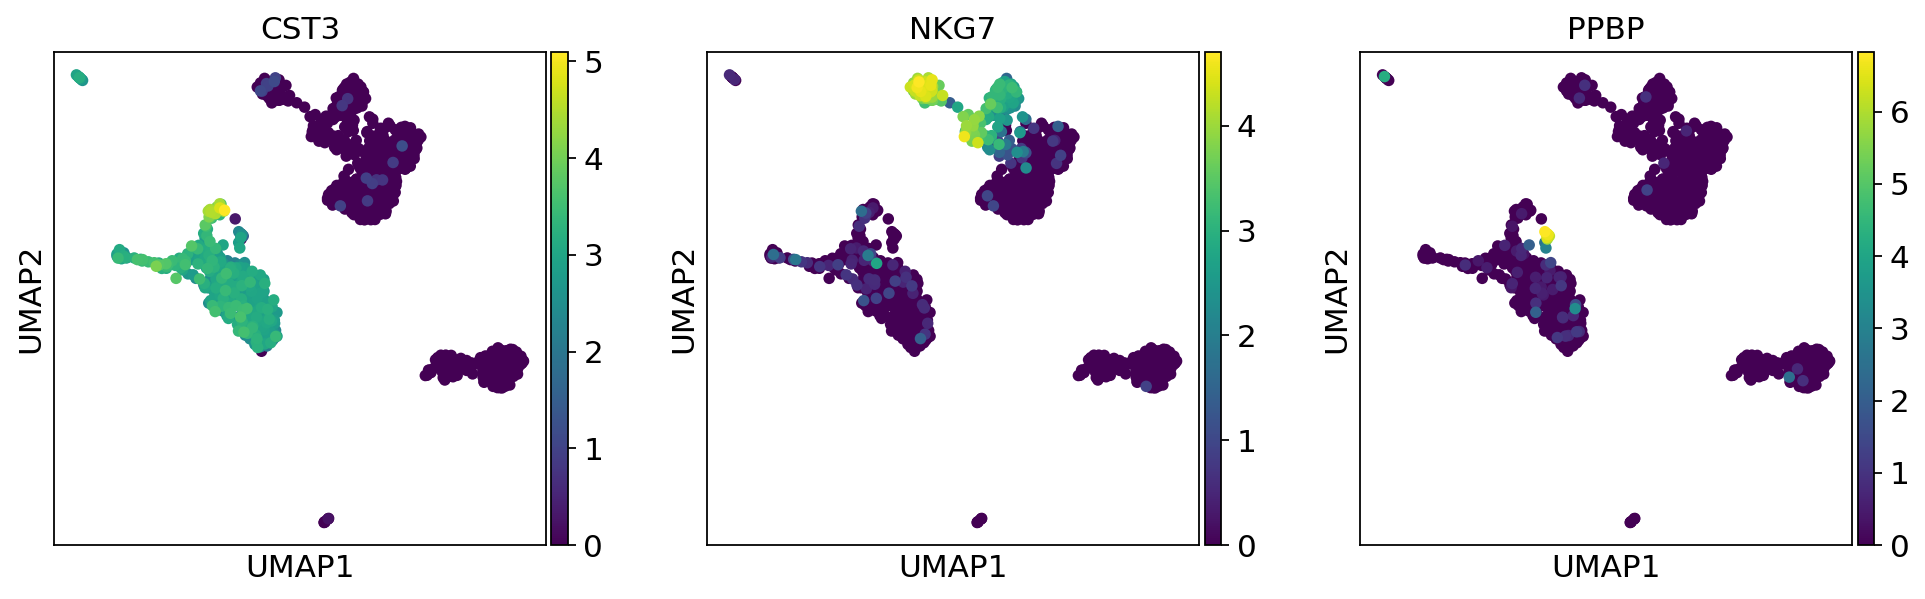

In [42]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

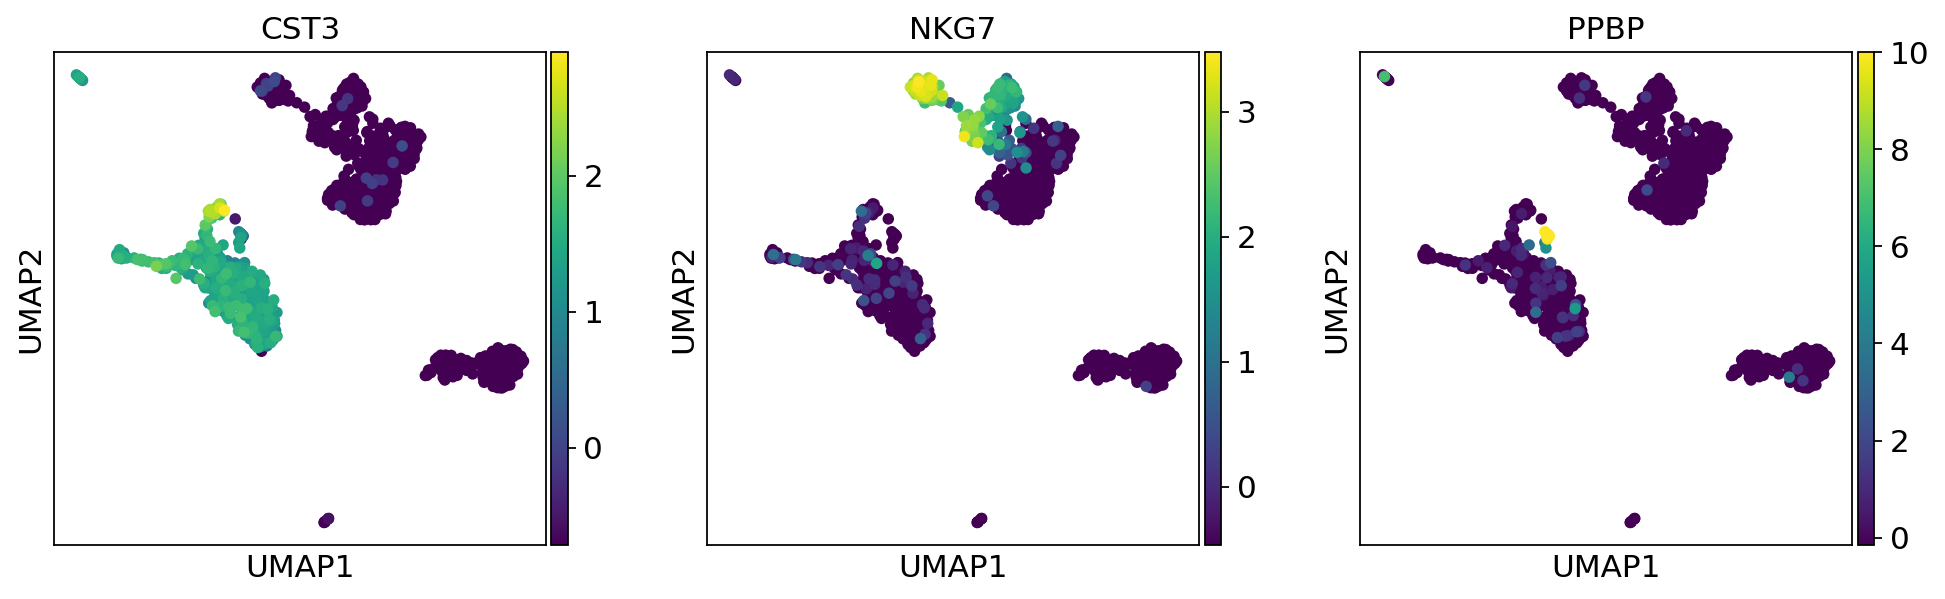

In [43]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

### Cluster the neighborhood graph

As Seurat and many others, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [44]:
sc.tl.leiden(adata,resolution=0.2)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

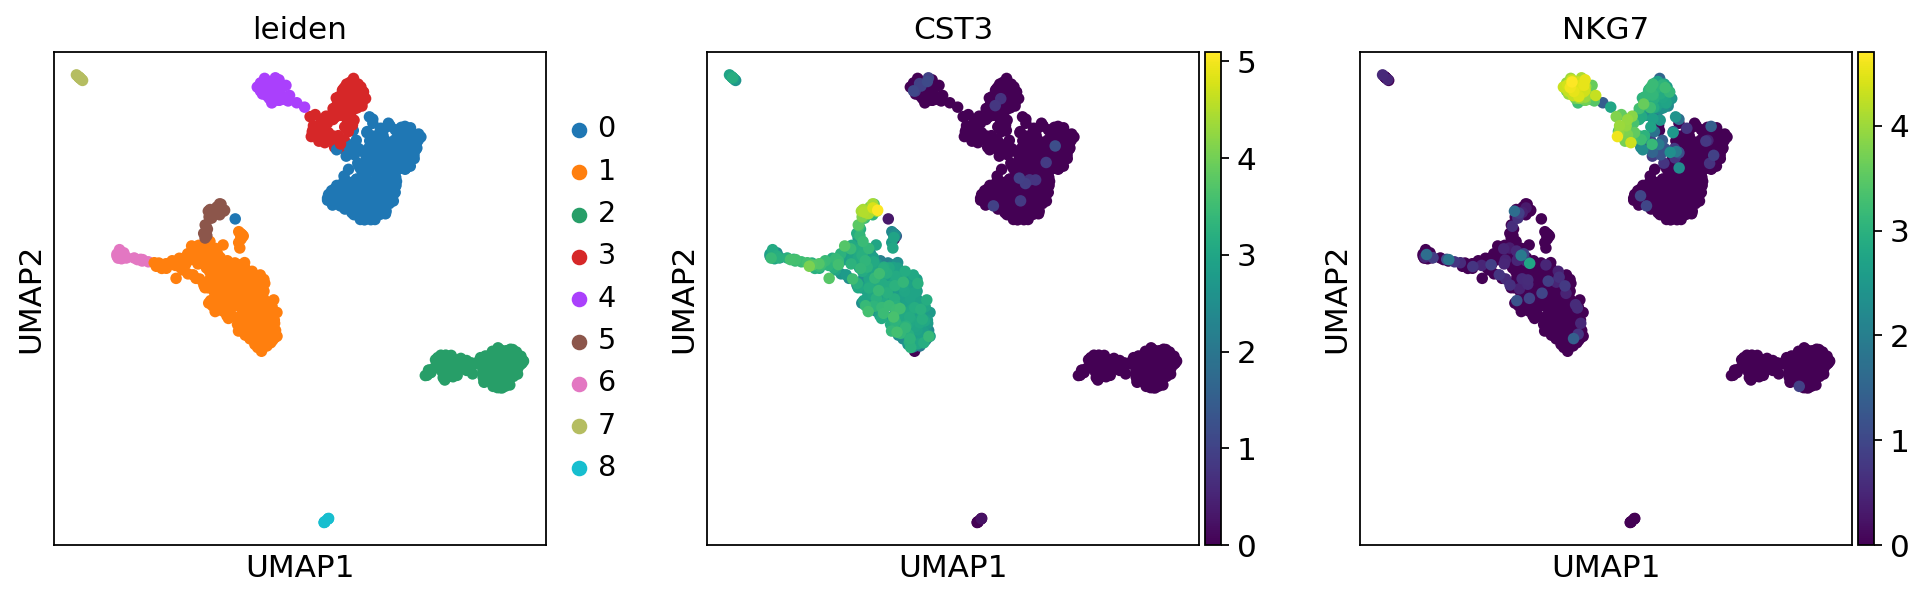

In [45]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

Save the result.

In [0]:
adata.write(results_file)

### Find marker genes

A key aspect of annotating a cell atlas is identifying "marker genes". These are genes specific to individual clusters that "mark" them, and are important both for assigning functions to cell clusters, and for designing downstream experiments to probe activity of clusters. 

A gene marker analysis begins with ranking genes in each cluster according to how different they are relative to other clusters. Typically the t-test is used for this purpose.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


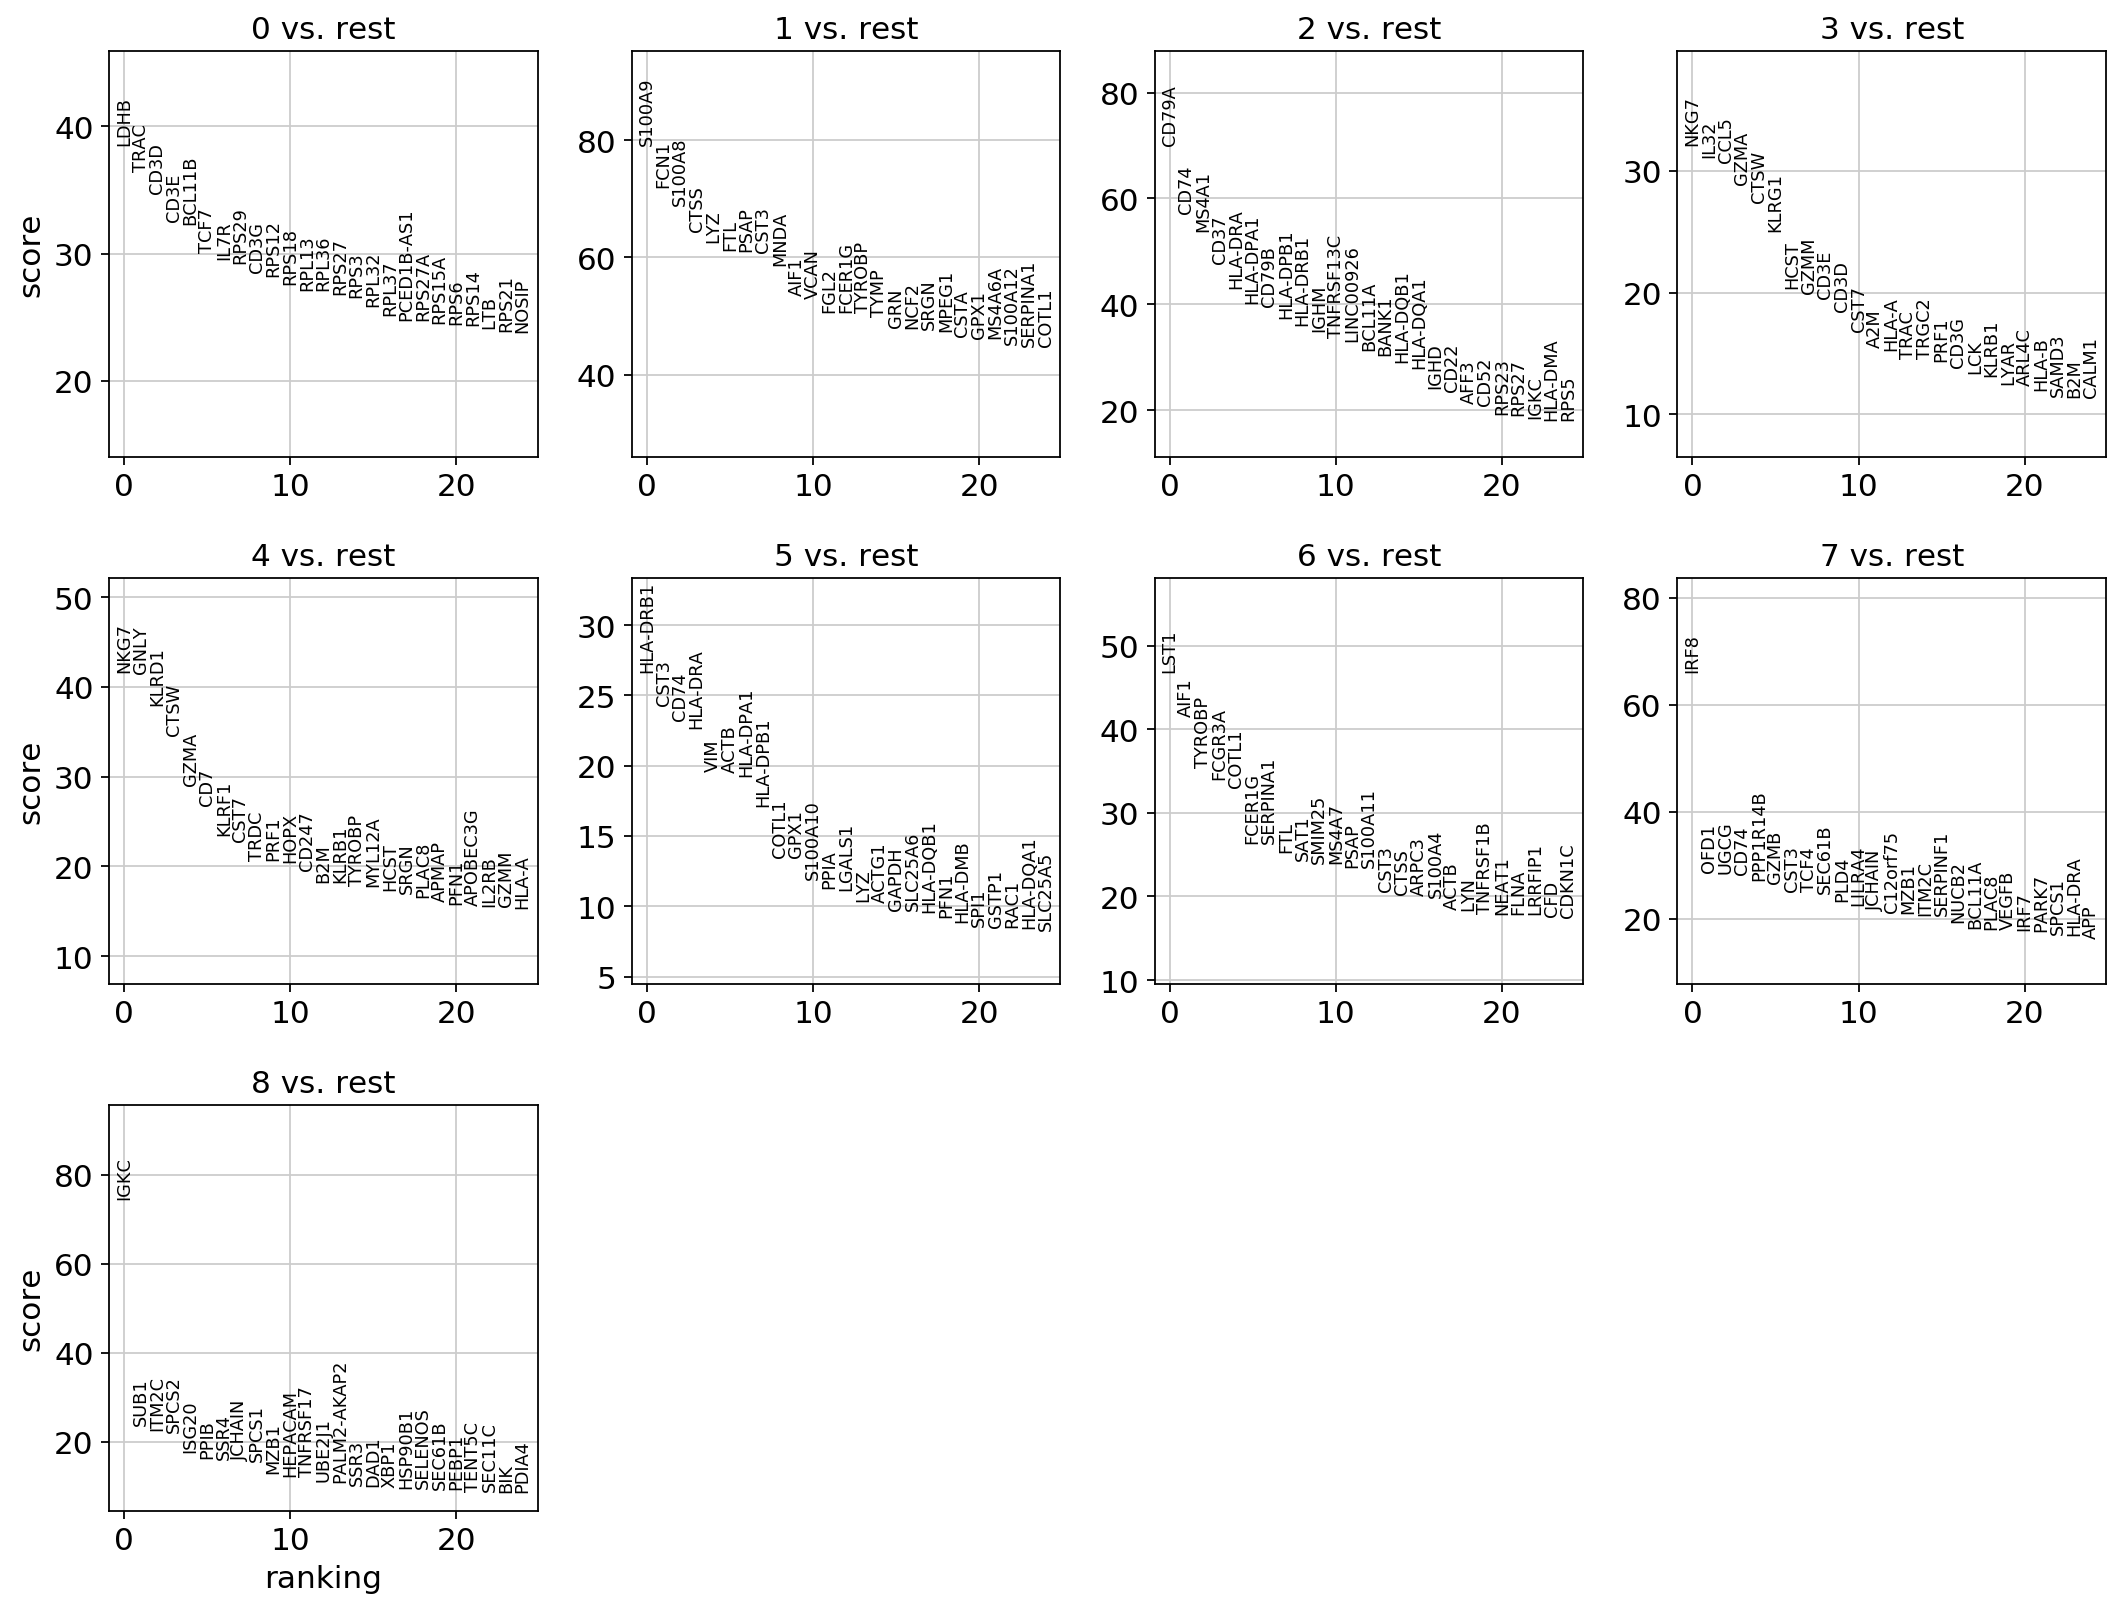

In [47]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [0]:
sc.settings.verbosity = 2  # reduce the verbosity

An alternative to the parametric t-test is the non-parametric [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test.

ranking genes
    finished (0:00:02)


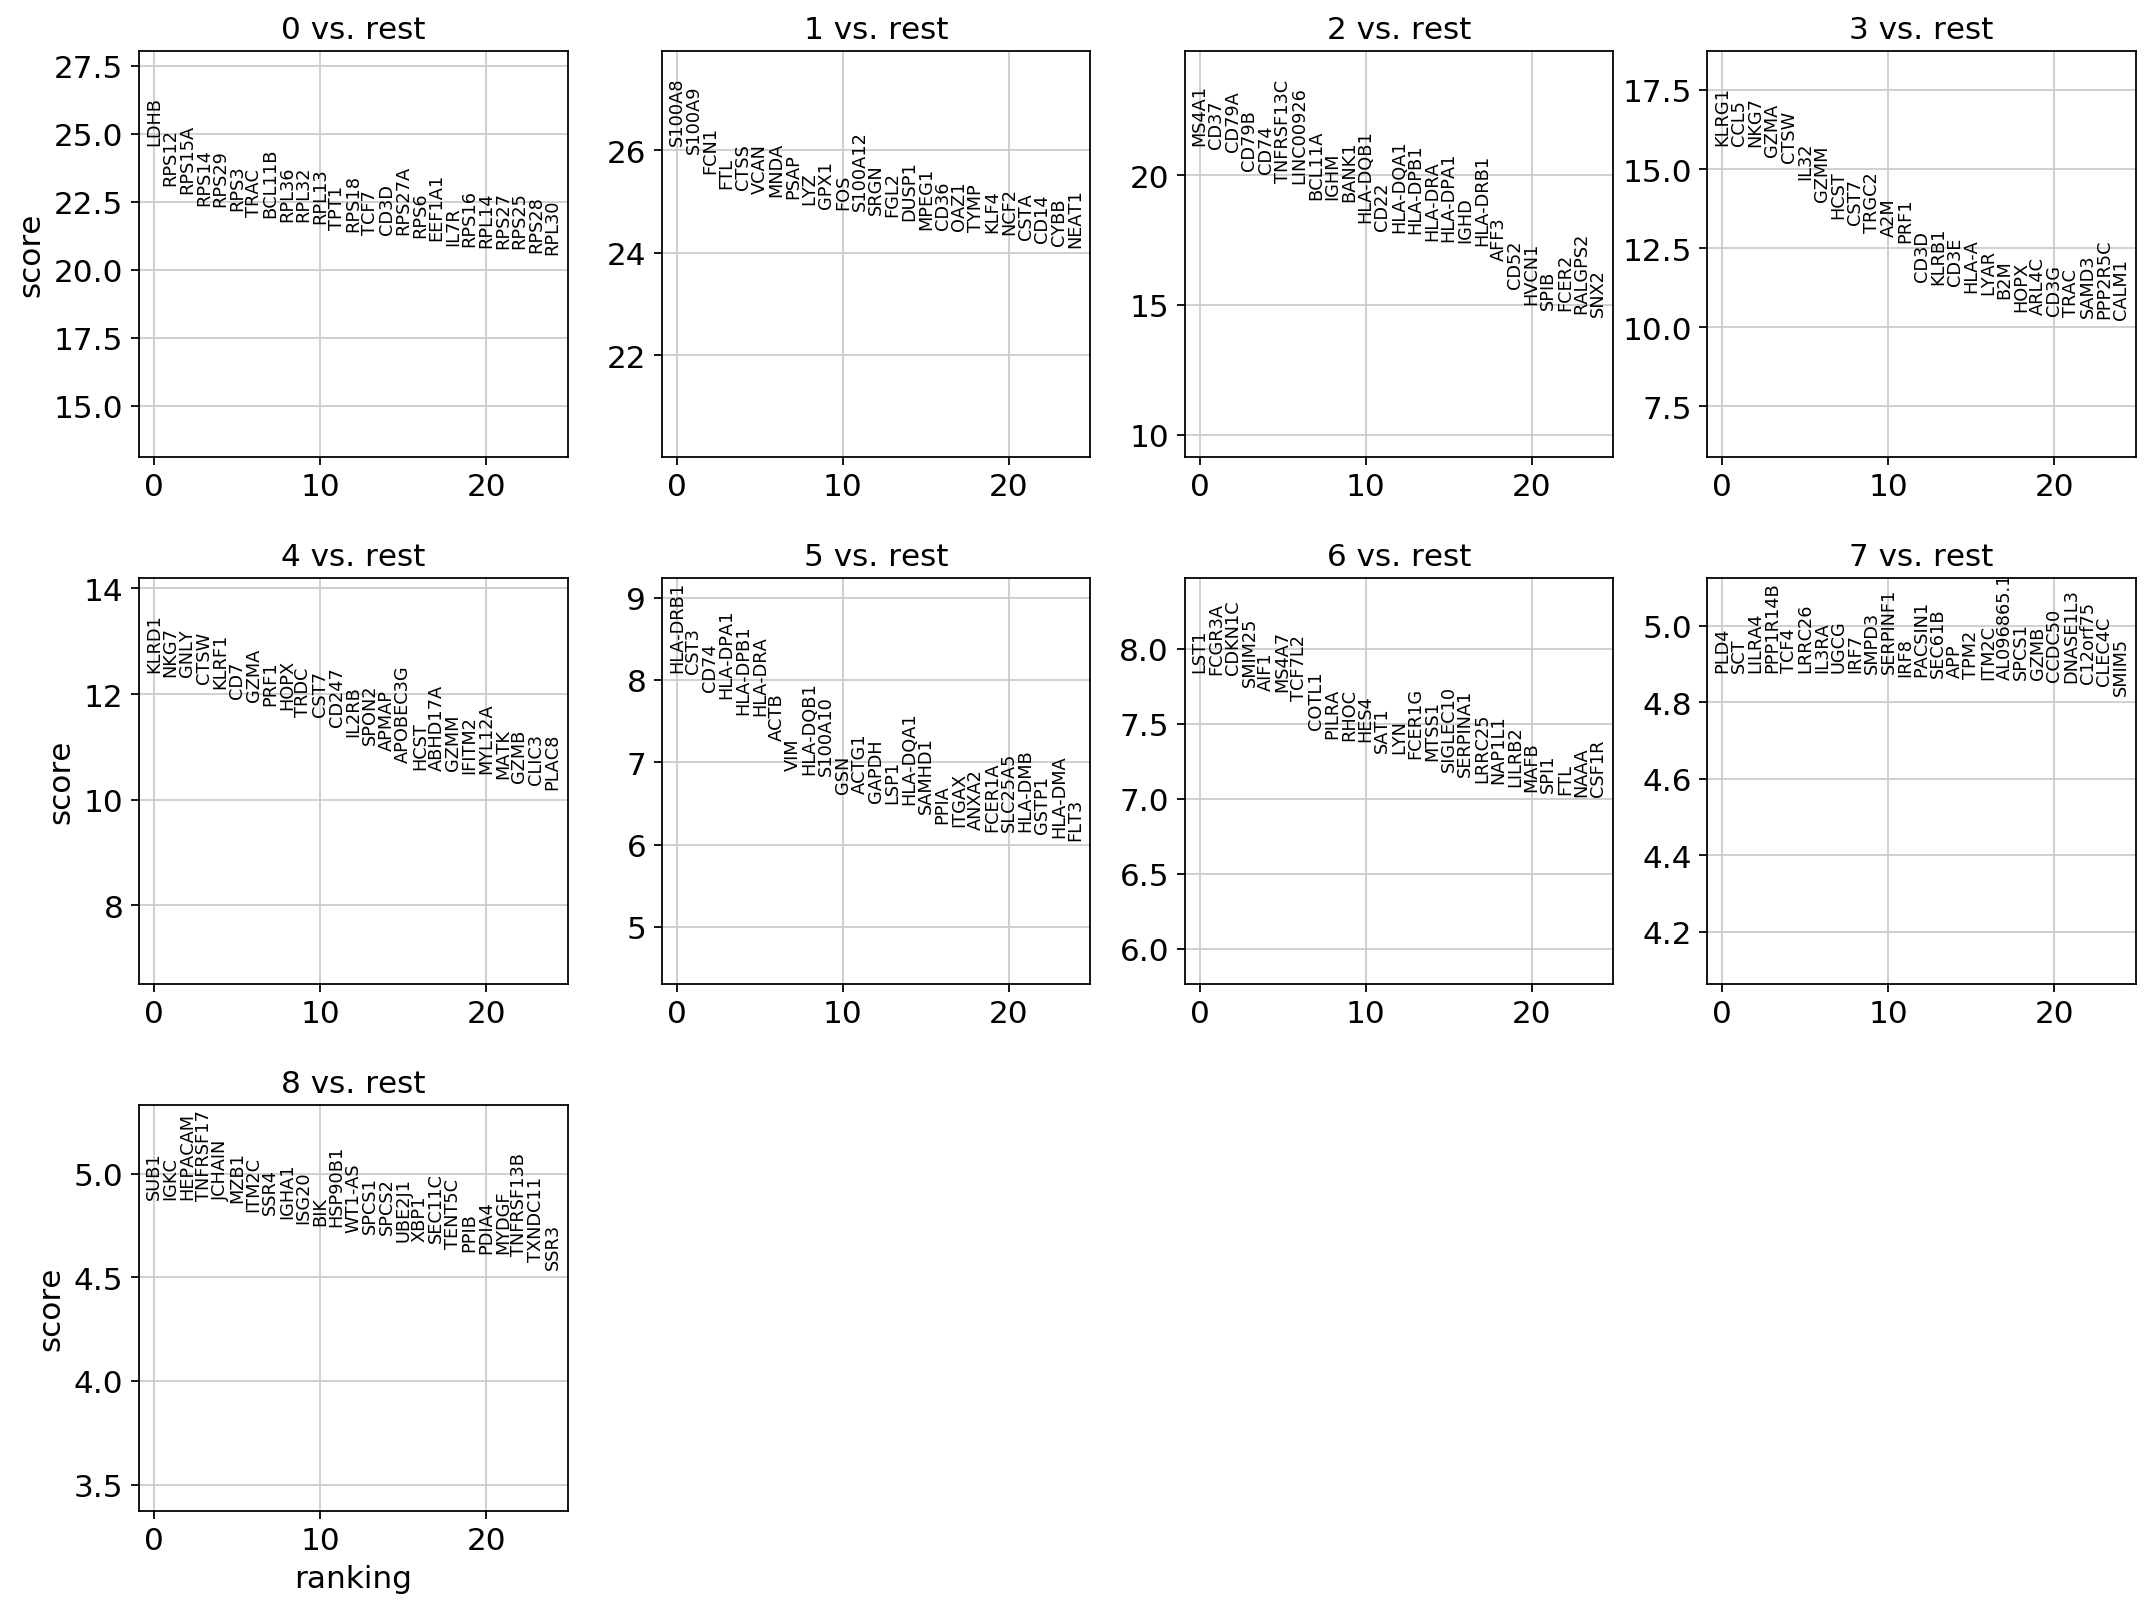

In [49]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [0]:
adata.write(results_file)

As an alternative, genes can be ranked using logistic regression (see [Natranos et al. (2018)](https://doi.org/10.1101/258566)).

ranking genes
    finished (0:00:17)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


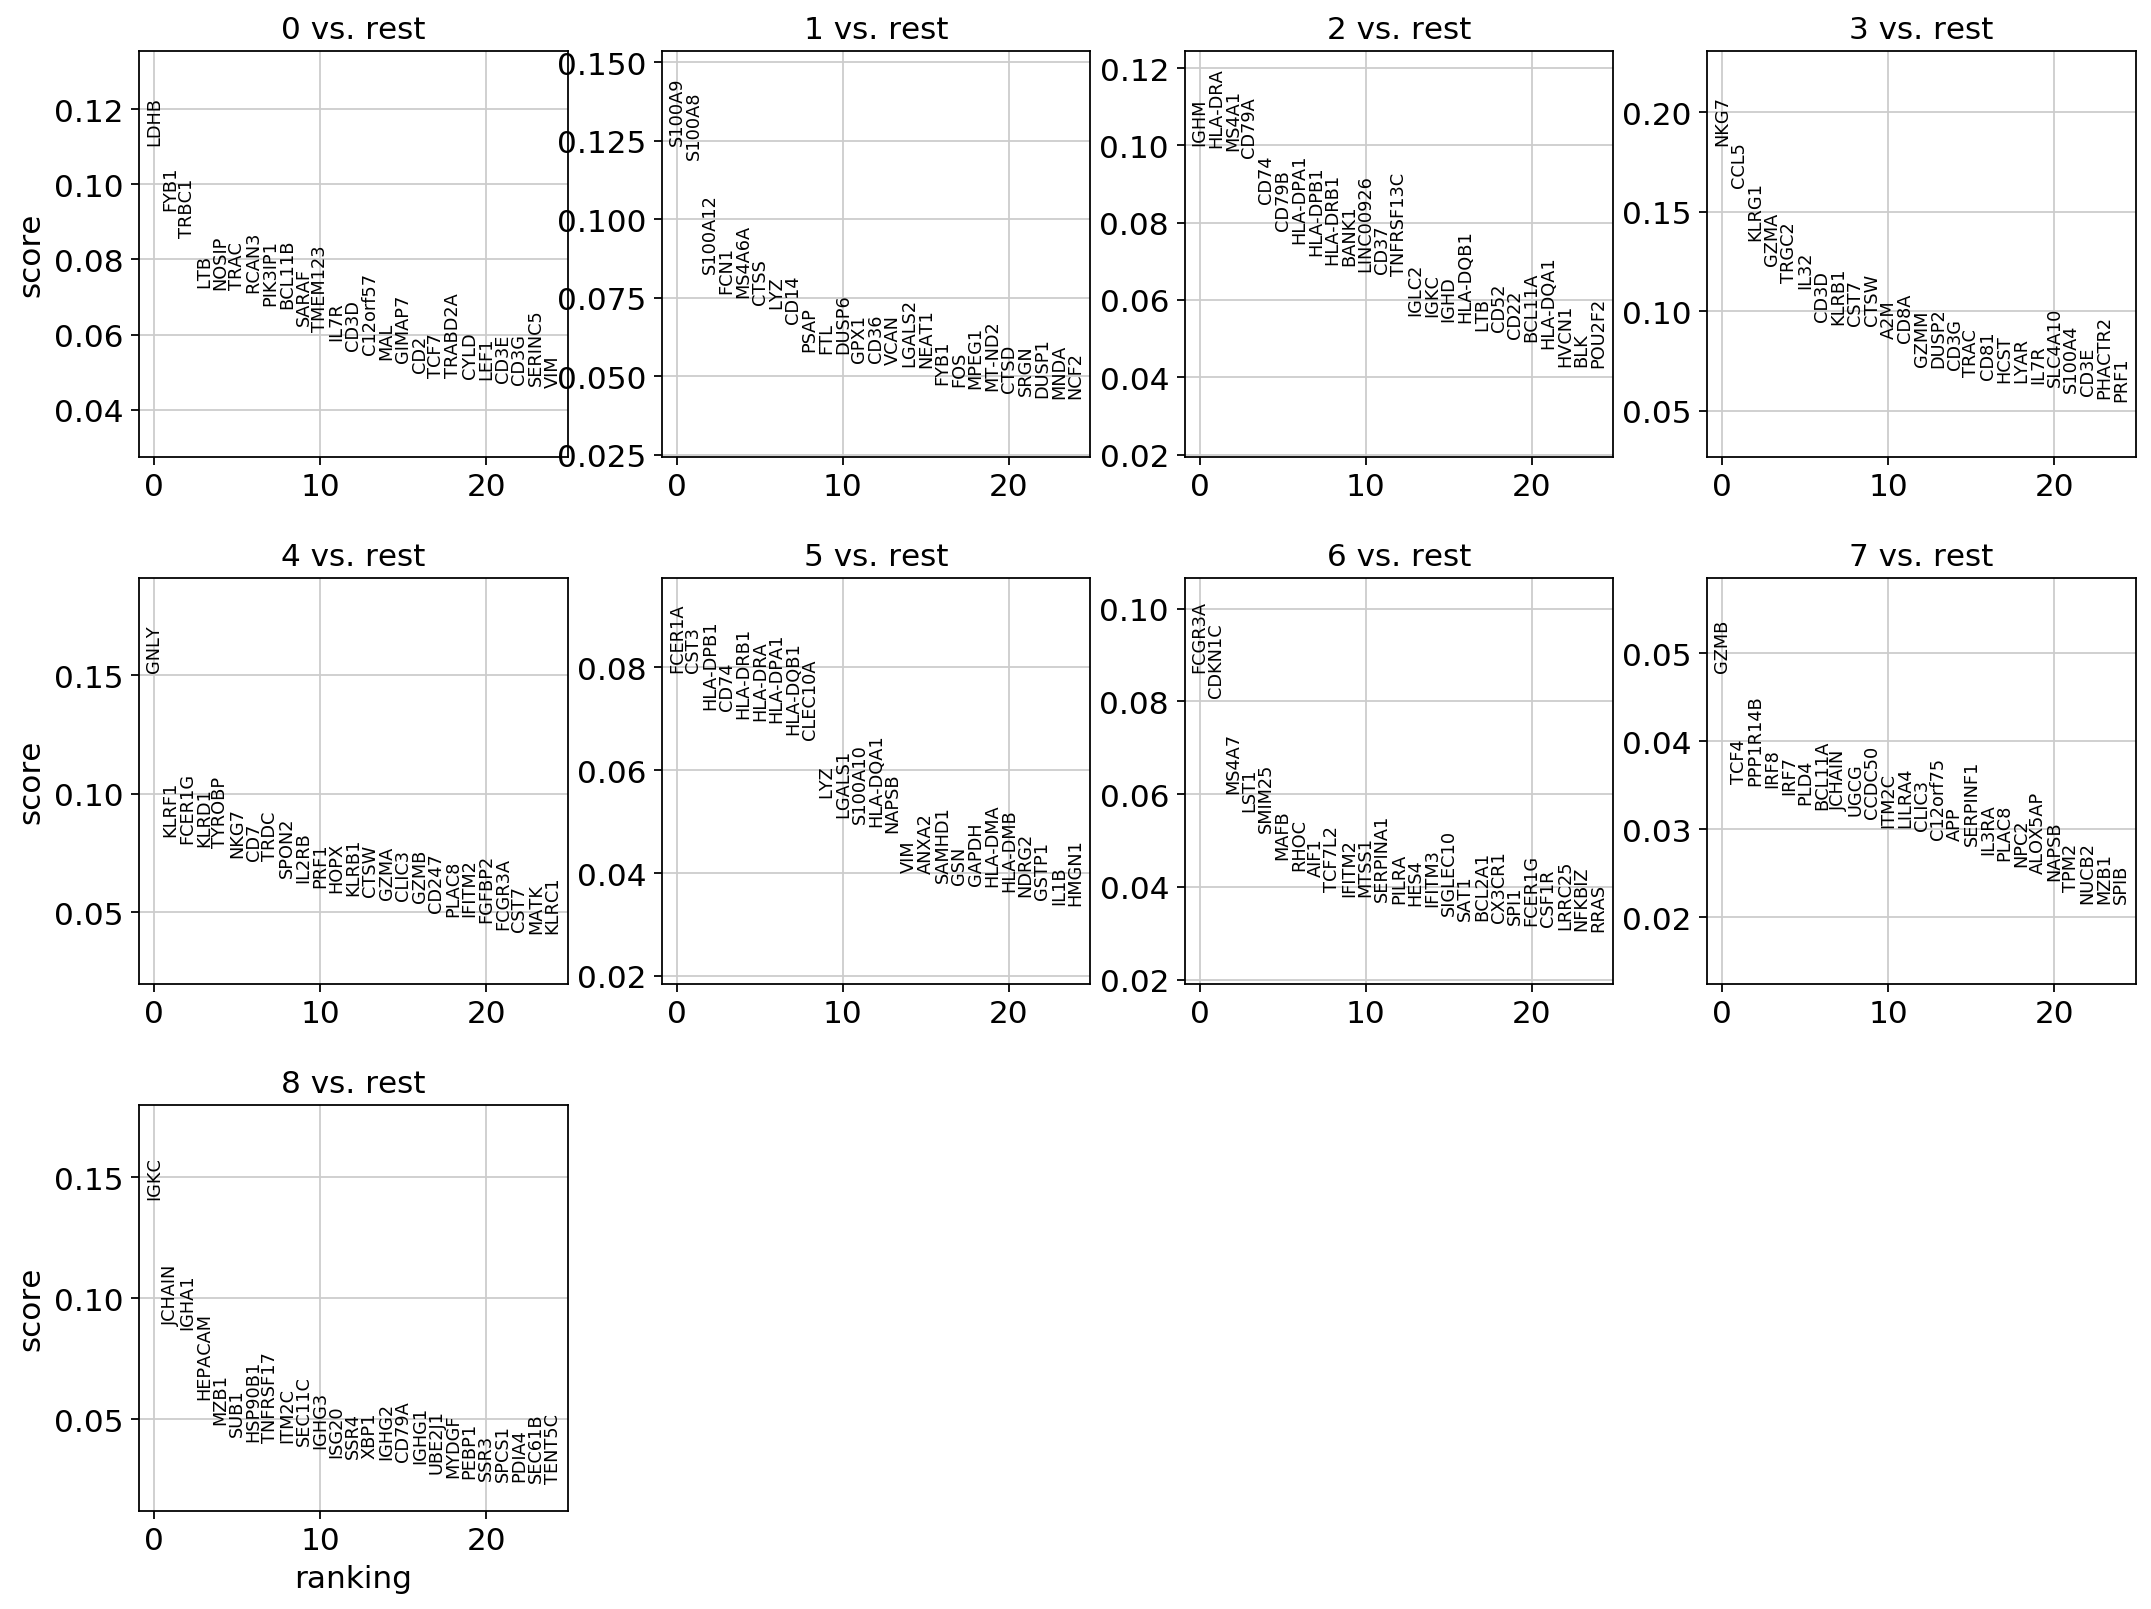

In [51]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

In [0]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [0]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [54]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8
0,LDHB,S100A8,MS4A1,KLRG1,KLRD1,HLA-DRB1,LST1,PLD4,SUB1
1,RPS12,S100A9,CD37,CCL5,NKG7,CST3,FCGR3A,SCT,IGKC
2,RPS15A,FCN1,CD79A,NKG7,GNLY,CD74,CDKN1C,LILRA4,HEPACAM
3,RPS14,FTL,CD79B,GZMA,CTSW,HLA-DPA1,SMIM25,PPP1R14B,TNFRSF17
4,RPS29,CTSS,CD74,CTSW,KLRF1,HLA-DPB1,AIF1,TCF4,JCHAIN


Get a table with the scores and groups.

In [55]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p
0,LDHB,1.762027e-133,S100A8,3.462191e-150,MS4A1,2.065194e-99,KLRG1,5.538666e-56,KLRD1,2.011742e-35,HLA-DRB1,5.557118e-16,LST1,4.288131e-15,PLD4,0.000001,SUB1,0.000001
1,RPS12,4.847577e-118,S100A9,2.608949e-148,CD37,3.734847e-98,CCL5,6.101014e-56,NKG7,5.293570e-35,CST3,6.105672e-16,FCGR3A,4.727057e-15,SCT,0.000001,IGKC,0.000001
2,RPS15A,3.209903e-115,FCN1,5.240461e-144,CD79A,2.066203e-97,NKG7,1.144191e-55,GNLY,5.434520e-35,CD74,3.636464e-15,CDKN1C,4.936059e-15,LILRA4,0.000001,HEPACAM,0.000001
3,RPS14,9.394099e-111,FTL,9.395907e-141,CD79B,9.670573e-91,GZMA,1.353573e-53,CTSW,2.548079e-34,HLA-DPA1,7.310827e-15,SMIM25,9.066323e-15,PPP1R14B,0.000001,TNFRSF17,0.000001
4,RPS29,1.543830e-110,CTSS,1.094961e-140,CD74,1.283840e-89,CTSW,3.133288e-52,KLRF1,9.352161e-34,HLA-DPB1,3.314561e-14,AIF1,1.110861e-14,TCF4,0.000001,JCHAIN,0.000001


Compare to a single cluster. 

ranking genes
    finished (0:00:00)


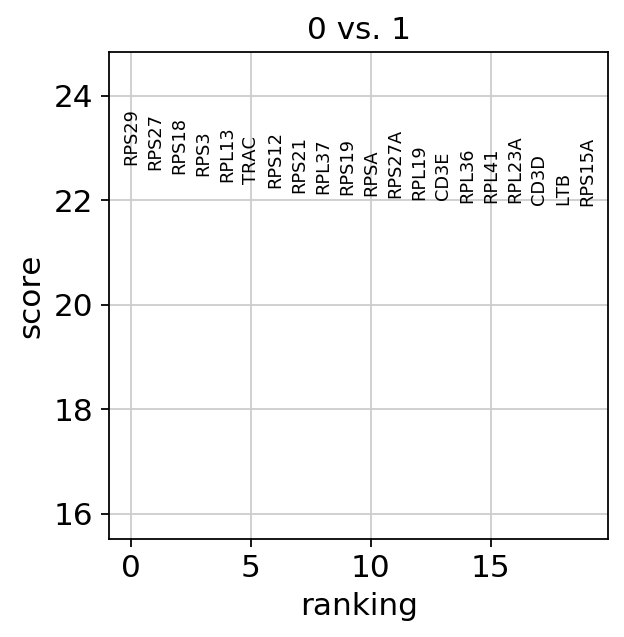

In [56]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

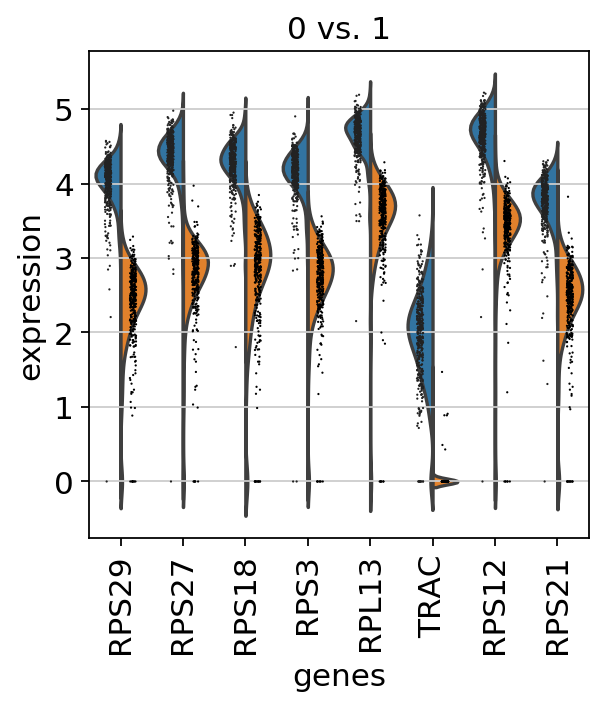

In [57]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object that computed differential expression by comparing to the rest of the groups.

In [0]:
adata = sc.read(results_file)

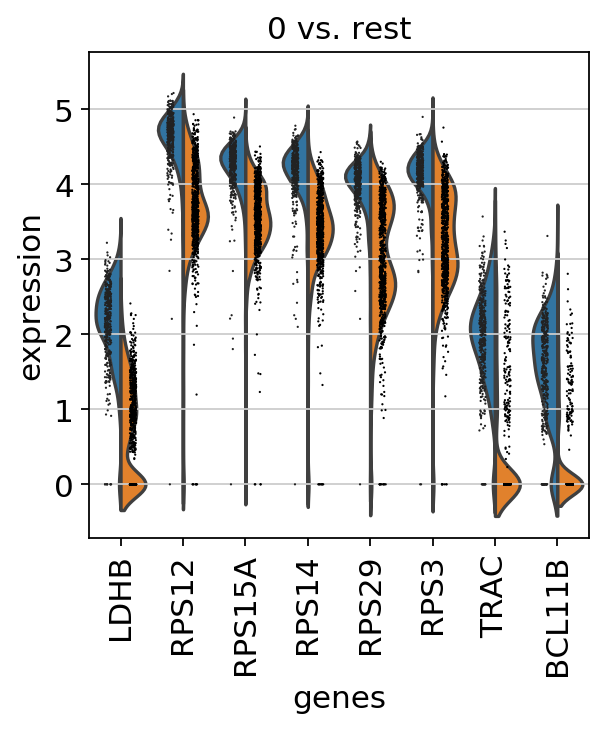

In [59]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

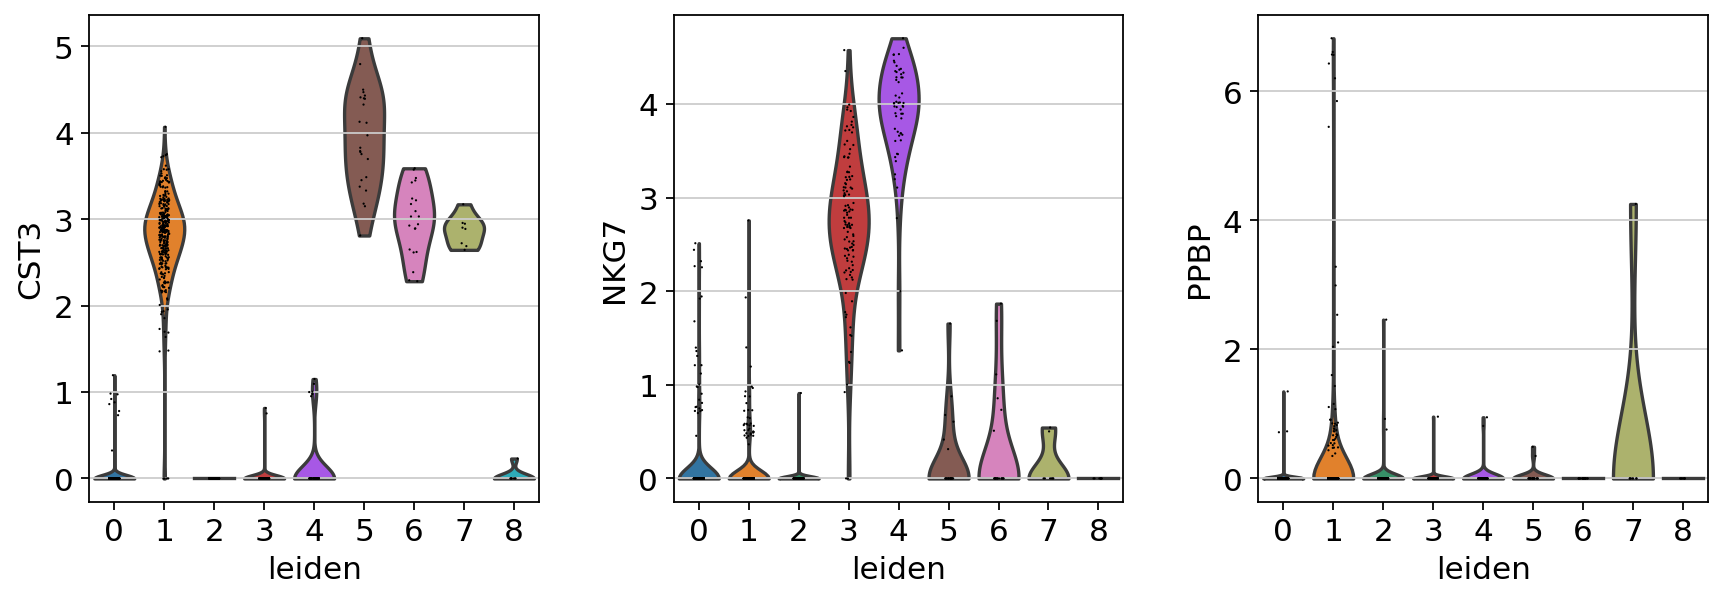

In [60]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

Actually mark the cell types.

In [0]:
 new_cluster_names = [
     'CD4 T', 'CD14 Monocytes',
     'B-1', 'CD8 T', 
     'NK', 'FCGR3A Monocytes',
     'Dendritic', 'Megakaryocytes','B-2']
 adata.rename_categories('leiden', new_cluster_names)

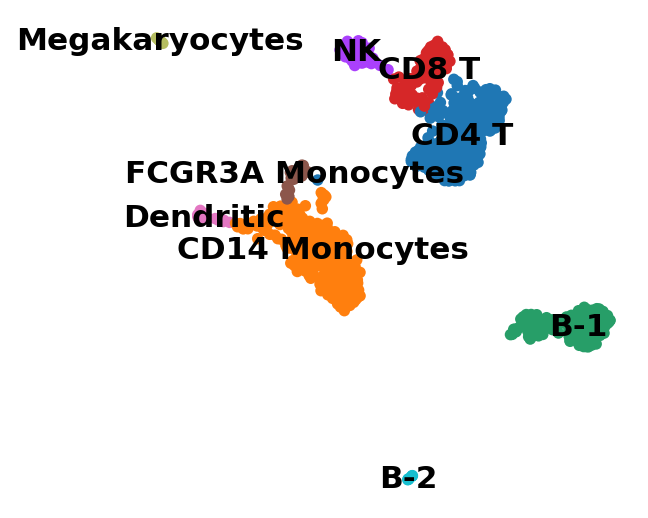

In [62]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False)

Now that we annotated the cell types, let us visualize the marker genes.

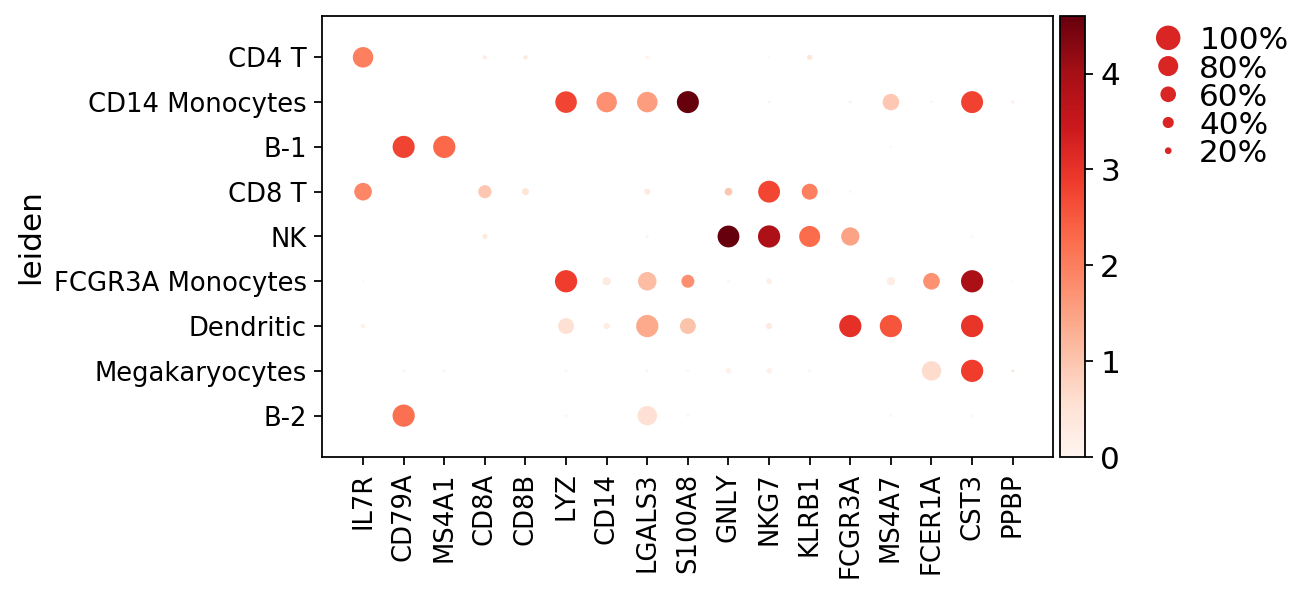

In [63]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='leiden')

There is also a very compact violin plot.

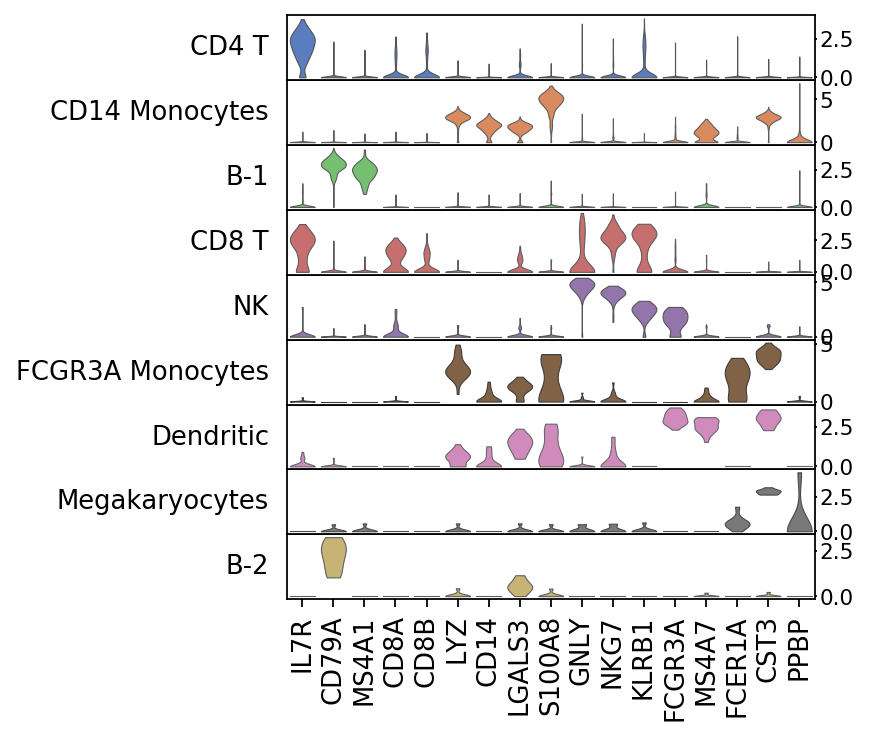

In [64]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)

Note that as a result of the analysis the adata object has accumulated several annotations:

In [65]:
adata

AnnData object with n_obs × n_vars = 1122 × 4344 
    obs: 'percent_mito', 'n_counts', 'n_genes', 'leiden'
    var: 'gene_id', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [0]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to export to "csv", you have the following options:

In [0]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )

In [68]:
# Running time of the notebook
print("{:.2f} minutes".format((time.time()-start_time)/60))

32.21 minutes
